<a href="https://colab.research.google.com/github/nemo0001/Python/blob/master/cardio.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#getting the data from PC

from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

Saving cardio_train.csv to cardio_train.csv
User uploaded file "cardio_train.csv" with length 2941524 bytes


In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from matplotlib import pyplot as plt
import tensorflow as tf
from tensorflow.keras.optimizers import RMSprop,Nadam,Adadelta,Adam
from tensorflow.keras.layers import BatchNormalization,LeakyReLU
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
import seaborn as sns
import scipy.stats as stats
import sklearn
import os


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [3]:
data_raw=pd.read_csv("cardio_train.csv",sep=";")
data_raw.head()

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,0,18393,2,168,62.0,110,80,1,1,0,0,1,0
1,1,20228,1,156,85.0,140,90,3,1,0,0,1,1
2,2,18857,1,165,64.0,130,70,3,1,0,0,0,1
3,3,17623,2,169,82.0,150,100,1,1,0,0,1,1
4,4,17474,1,156,56.0,100,60,1,1,0,0,0,0


In [4]:
data_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70000 entries, 0 to 69999
Data columns (total 13 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   id           70000 non-null  int64  
 1   age          70000 non-null  int64  
 2   gender       70000 non-null  int64  
 3   height       70000 non-null  int64  
 4   weight       70000 non-null  float64
 5   ap_hi        70000 non-null  int64  
 6   ap_lo        70000 non-null  int64  
 7   cholesterol  70000 non-null  int64  
 8   gluc         70000 non-null  int64  
 9   smoke        70000 non-null  int64  
 10  alco         70000 non-null  int64  
 11  active       70000 non-null  int64  
 12  cardio       70000 non-null  int64  
dtypes: float64(1), int64(12)
memory usage: 6.9 MB


In [5]:
data_raw.drop("id",axis=1,inplace=True)

In [6]:
#handling duplicate values
print("There is {} duplicated values in data frame".format(data_raw.duplicated().sum()))

There is 24 duplicated values in data frame


In [7]:
#We can drop the duplicates because they have no any effect of training of model.
#Firstly let us see the duplicated rows with eyes.
duplicated = data_raw[data_raw.duplicated(keep=False)]
duplicated = duplicated.sort_values(by=['age', "gender", "height"], ascending= False) 
# I sorted the values to see duplication clearly

duplicated.head(2) # Show us just 1 duplication of 24

,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
2677,22077,1,175,69.0,120,80,1,1,0,0,1,1
45748,22077,1,175,69.0,120,80,1,1,0,0,1,1


In [8]:
data_raw.drop_duplicates(inplace=True)
print("There is {} duplicated values in data frame".format(data_raw.duplicated().sum()))

There is 0 duplicated values in data frame


In [9]:
print("There is {} missing values in data frame".format(data_raw.isnull().sum().sum()))

There is 0 missing values in data frame


In [10]:
#VISUALIZATION
#Detecting Outliers 
#Detecting outlier and handling them can increase our accuracy score.
x = data_raw.copy(deep=True)
x.describe()

,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
count,69976.000000,69976.000000,69976.000000,69976.000000,69976.000000,69976.000000,69976.000000,69976.000000,69976.000000,69976.000000,69976.000000,69976.000000
mean,19468.950126,1.349648,164.359152,74.208519,128.820453,96.636261,1.366997,1.226535,0.088159,0.053790,0.803718,0.499771
std,2467.374620,0.476862,8.211218,14.397211,154.037729,188.504581,0.680333,0.572353,0.283528,0.225604,0.397187,0.500004
min,10798.000000,1.000000,55.000000,10.000000,-150.000000,-70.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,17664.000000,1.000000,159.000000,65.000000,120.000000,80.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000
50%,19703.000000,1.000000,165.000000,72.000000,120.000000,80.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000
75%,21327.000000,2.000000,170.000000,82.000000,140.000000,90.000000,2.000000,1.000000,0.000000,0.000000,1.000000,1.000000
max,23713.000000,2.000000,250.000000,200.000000,16020.000000,11000.000000,3.000000,3.000000,1.000000,1.000000,1.000000,1.000000


In [11]:
#Columns of "age", "height", "weight", "ap_hi", "ap_lo" may have outlier.
#In order to compare them on same scale we need to standardize firstly.
#My Standart Scalar Function
s_list = ["age", "height", "weight", "ap_hi", "ap_lo"]
def standartization(x):
    x_std = x.copy(deep=True)
    for column in s_list:
        x_std[column] = (x_std[column]-x_std[column].mean())/x_std[column].std()
    return x_std 
x_std=standartization(x)
x_std.head()

,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,-0.436071,2,0.443399,-0.847978,-0.122181,-0.088254,1,1,0,0,1,0
1,0.307635,1,-1.018016,0.749554,0.072577,-0.035205,3,1,0,0,1,1
2,-0.248017,1,0.078045,-0.709062,0.007658,-0.141303,3,1,0,0,0,1
3,-0.748143,2,0.565184,0.541180,0.137496,0.017844,1,1,0,0,1,1
4,-0.808532,1,-1.018016,-1.264725,-0.187100,-0.194352,1,1,0,0,0,0


In [12]:
#Visualization
#In order to use the multi box graph plot we need to melt out data.
x_melted = pd.melt(frame=x_std, id_vars="cardio", value_vars=s_list, var_name="features", value_name="value", col_level=None)
x_melted

,cardio,features,value
0,0,age,-0.436071
1,1,age,0.307635
2,1,age,-0.248017
3,1,age,-0.748143
4,0,age,-0.808532
...,...,...,...
349875,0,ap_lo,-0.088254
349876,1,ap_lo,-0.035205
349877,1,ap_lo,-0.035205
349878,1,ap_lo,-0.088254


(array([0, 1, 2, 3, 4]), <a list of 5 Text major ticklabel objects>)

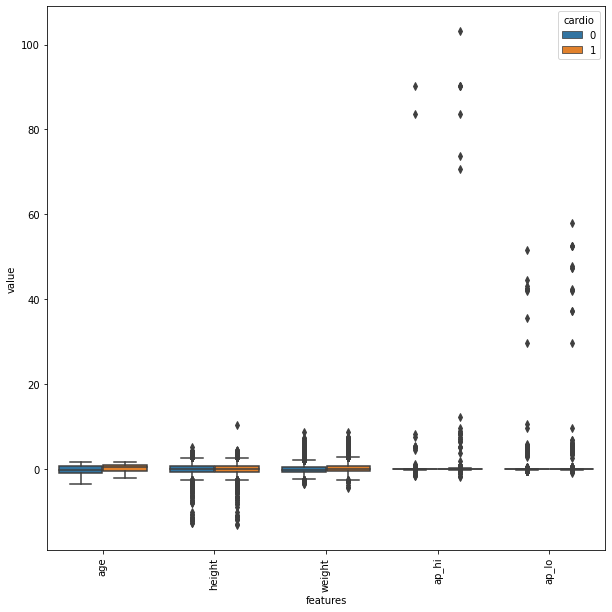

In [13]:
plt.figure(figsize=(10,10))
sns.boxplot(x="features", y="value", hue="cardio", data=x_melted)
plt.xticks(rotation=90)

In [14]:
#There are some outliers in the dataset, but as seen above there is an unusual outlier in ap_hi and ap_lo features.
#Let us calculate the low bound and hi bound of ap_lo and ap_hi features
ap_list = ["ap_hi", "ap_lo"]
boundary = pd.DataFrame(index=["lower_bound","upper_bound"]) # We created an empty dataframe
for each in ap_list:
    Q1 = x[each].quantile(0.25)
    Q3 = x[each].quantile(0.75)
    IQR = Q3 - Q1

    lower_bound = Q1- 1.5*IQR
    upper_bound = Q3 + 1.5*IQR
    boundary[each] = [lower_bound, upper_bound ]
boundary

,ap_hi,ap_lo
lower_bound,90.0,65.0
upper_bound,170.0,105.0


In [15]:
#We can select the index of outlier data by using boundaries we calculated.
#Normally we should analyze both upper outliers and below outliers but in this case, I consider to handle 
#just uppers because of their extremely higher values.
ap_hi_filter = (x["ap_hi"] > boundary["ap_hi"][1])
ap_lo_filter = (x["ap_lo"] > boundary["ap_lo"][1])                                                           
outlier_filter = (ap_hi_filter | ap_lo_filter)
x_outliers = x[outlier_filter]
x_outliers["cardio"].value_counts()

1    2025
0     388
Name: cardio, dtype: int64

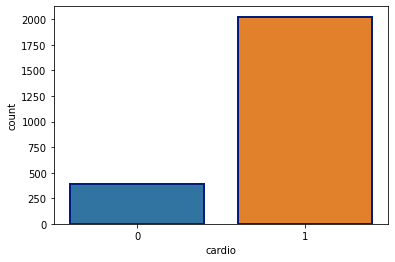

In [16]:
#Cardiovascular disease is present in 83 percent of the ap_hi and ap_lo outlier data,
#Because of ap_hi and ap_lo symbolizes high blood pressure, the high rate of disease is consistent with real life.
#For this reason, I decided to drop just medically impossible data from the dataset.
#And I have dropped some of data because we have sufficent data (70000) otherwise I would try to handle them by assigning new values.
sns.countplot(x='cardio',data=x_outliers,linewidth=2,edgecolor=sns.color_palette("dark", 1))

In [17]:
#A study published by doctors in NCBI NLM recorded a maximum blood pressure of 370/360 mm Hg. This study was performed by recording blood pressure in 10 male athletes through radial artery catheterization.
#Thus we can drop the ap_hi outlier values over 250 and ap_lo outlier values over 200, without fear of missing data.
out_filter = ((x["ap_hi"]>250) | (x["ap_lo"]>200) )
print("There is {} outlier".format(x[out_filter]["cardio"].count()))

There is 993 outlier


,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
age,1.000000,-0.022988,-0.080726,0.055206,0.195915,0.150519,0.155328,0.099134,-0.047779,-0.029055,-0.010368,0.239735
gender,-0.022988,1.000000,0.498026,0.155823,0.056949,0.064708,-0.036813,-0.021055,0.338627,0.170974,0.005487,0.007456
height,-0.080726,0.498026,1.000000,0.291532,0.017727,0.035771,-0.050458,-0.018512,0.187974,0.094475,-0.007302,-0.010400
weight,0.055206,0.155823,0.291532,1.000000,0.253299,0.244889,0.140577,0.106854,0.066738,0.067900,-0.017901,0.179876
ap_hi,0.195915,0.056949,0.017727,0.253299,1.000000,0.640397,0.184618,0.087632,0.028228,0.031559,0.000949,0.397351
ap_lo,0.150519,0.064708,0.035771,0.244889,0.640397,1.000000,0.155268,0.075991,0.024611,0.042912,-0.001050,0.328110
cholesterol,0.155328,-0.036813,-0.050458,0.140577,0.184618,0.155268,1.000000,0.450800,0.009811,0.035566,0.008949,0.221358
gluc,0.099134,-0.021055,-0.018512,0.106854,0.087632,0.075991,0.450800,1.000000,-0.005703,0.011207,-0.007726,0.089727
smoke,-0.047779,0.338627,0.187974,0.066738,0.028228,0.024611,0.009811,-0.005703,1.000000,0.340274,0.025729,-0.016371
alco,-0.029055,0.170974,0.094475,0.067900,0.031559,0.042912,0.035566,0.011207,0.340274,1.000000,0.025338,-0.008151


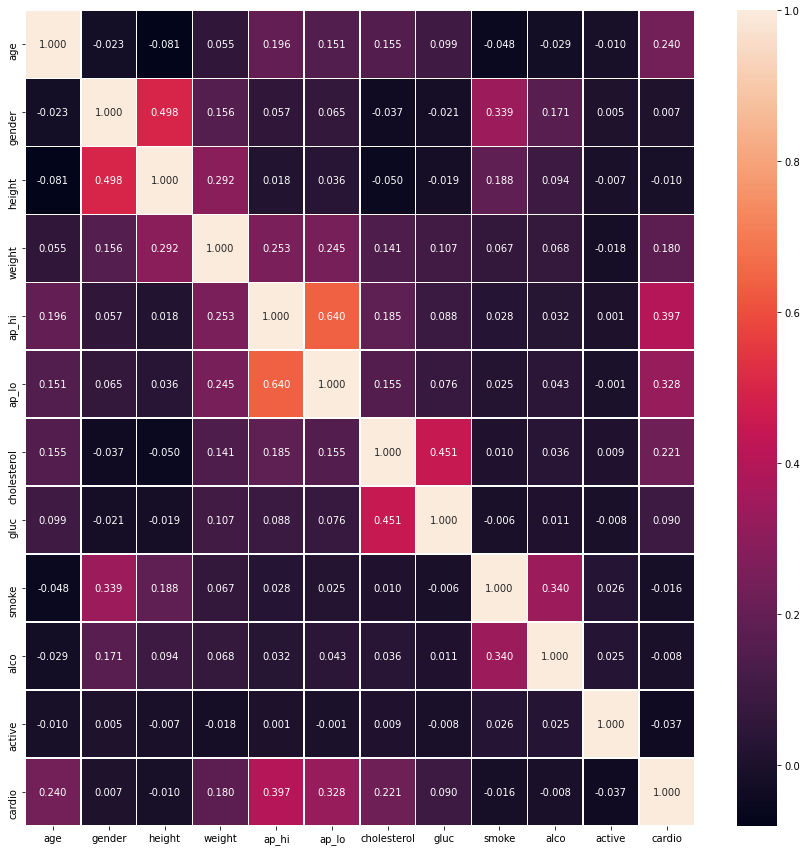

In [18]:
x = x[~out_filter]
corr = x.corr()
f, ax = plt.subplots(figsize = (15,15))
sns.heatmap(corr, annot=True, fmt=".3f", linewidths=0.5, ax=ax)
corr

#We can see from correlation map easily; cholesterol, blood pressure (ap_hi and ap_low both) and age have a powerful relationship with cardiovascular diseases.
#Glucogen and cholesterol have a strong relationship among them either.

In [19]:
#Calculating BMI
def bmi_calc(w, h):
    return w/(h**2)
x["bmi"] = x["weight"]/ (x["height"]/100)**2

x.head()

,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio,bmi
0,18393,2,168,62.0,110,80,1,1,0,0,1,0,21.967120
1,20228,1,156,85.0,140,90,3,1,0,0,1,1,34.927679
2,18857,1,165,64.0,130,70,3,1,0,0,0,1,23.507805
3,17623,2,169,82.0,150,100,1,1,0,0,1,1,28.710479
4,17474,1,156,56.0,100,60,1,1,0,0,0,0,23.011177


In [20]:
#gender detection
a = x[x["gender"]==1]["height"].mean()
b = x[x["gender"]==2]["height"].mean()
if a > b:
    gender = "male"
    gender2 = "female"
else:
    gender = "female"
    gender2 = "male"
print("Gender:1 is "+ gender +" & Gender:2 is " + gender2)

#We did not change other categorical code to one hot encoding because they express really hierarchical size
#An example from describtion of dataset : Cholesterol | 1: normal, 2: above normal, 3: well above normal

Gender:1 is female & Gender:2 is male


In [21]:
x["gender"] = x["gender"] % 2

(array([0, 1]), <a list of 2 Text major ticklabel objects>)

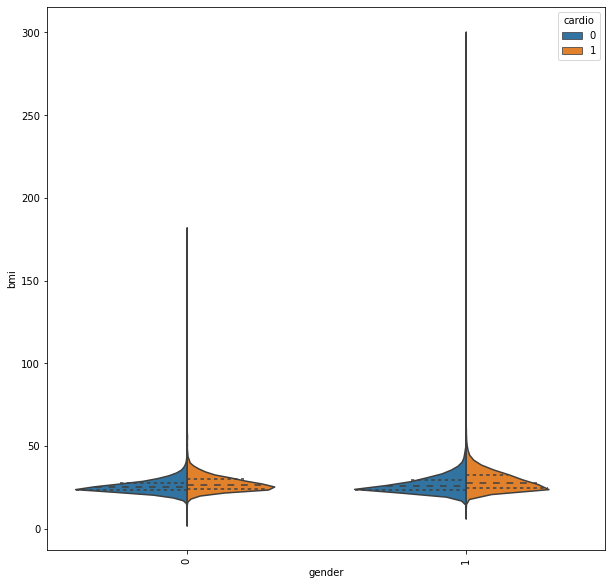

In [22]:
from sklearn.preprocessing import StandardScaler
x_std = standartization(x)

data = pd.melt(x_std,id_vars="cardio",
                    var_name="features",
                    value_name='value')
plt.figure(figsize=(10,10))
sns.violinplot(x="gender", y="bmi", hue="cardio", data=x,split=True, inner="quart")
plt.xticks(rotation=90)
#If we interpret the violin plot, the median and quartiles of bmi distribution of patients is slightly higher than non-patients.

In [23]:
y = x["cardio"]
y.shape
x.drop("cardio", axis=1,inplace=True)
x.head()

#train-test split
from sklearn.model_selection import train_test_split
x_train,x_test, y_train, y_test = train_test_split(x,y,test_size=0.2,random_state=42)

#Normalization
from sklearn.preprocessing import normalize
x_train = normalize(x_train)
x_test = normalize(x_test)
x = normalize(x)

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB

dec = DecisionTreeClassifier()
ran = RandomForestClassifier(n_estimators=100)
knn = KNeighborsClassifier(n_neighbors=100)
svm = SVC(random_state=1)
naive = GaussianNB()

#models to be fitted
models = {"Decision tree" : dec,
          "Random forest" : ran,
          "KNN" : knn,
          "SVM" : svm,
          "Naive bayes" : naive}
scores= { }

for key, value in models.items():    
    model = value
    model.fit(x_train, y_train)
    scores[key] = model.score(x_test, y_test)

In [30]:
scores

{'Decision tree': 0.6318040153656592,
 'KNN': 0.7130535623686308,
 'Naive bayes': 0.630861781546713,
 'Random forest': 0.7152279481046604,
 'SVM': 0.505907081249547}

In [24]:
scores_frame = pd.DataFrame(scores, index=["Accuracy Score"]).T
scores_frame.sort_values(by=["Accuracy Score"], axis=0 ,ascending=False, inplace=True)
scores_frame

,Accuracy Score
Random forest,0.715228
KNN,0.713054
Decision tree,0.631804
Naive bayes,0.630862
SVM,0.505907


(array([0, 1, 2, 3, 4]), <a list of 5 Text major ticklabel objects>)

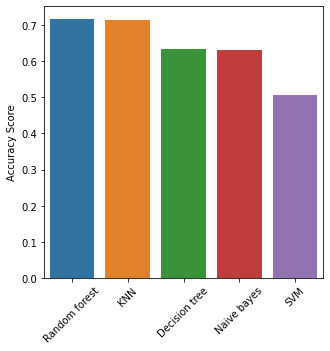

In [27]:
plt.figure(figsize=(5,5))
sns.barplot(x=scores_frame.index,y=scores_frame["Accuracy Score"])
plt.xticks(rotation=45) 
# Rotation of model names...

In [28]:
#K Fold Cross Validation
#With K-Fold cross-validation, we obtain "K" pieces of results from different mini-training sets from our main training set.
#Then we choose the average of these results as the actual result.
#After all, by taking the standard deviation of K result, we can examine whether the data is consistent.
from sklearn.model_selection import cross_val_score
accuracies_random_forest = cross_val_score(estimator=ran, X=x_train, y=y_train, cv=10)
accuracies_knn = cross_val_score(estimator=knn, X=x_train, y=y_train, cv=10)

In [29]:
print("Random Forest Average accuracy: ", accuracies_random_forest.mean())
print("Random Forest Standart Deviation: ", accuracies_random_forest.std())
print("KNN Average accuracy: ", accuracies_knn.mean())
print("KNN Standart Deviation: ", accuracies_knn.std())

Random Forest Average accuracy:  0.7146557830043251
Random Forest Standart Deviation:  0.005896755713600398
KNN Average accuracy:  0.7134959917372659
KNN Standart Deviation:  0.006571724105971957
